In [1]:
from ckanapi import RemoteCKAN
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from pandas.io.json import json_normalize

ua = 'avoindata_ckanapi_example/1.0 ({0})'
ckan = RemoteCKAN('https://beta.avoindata.fi/data/fi/', user_agent=ua)
packages = ckan.action.package_search(q='Kansaneläkelaitos', fq = 'title:lapsilisän')
resources = packages['results'][0]['resources'] 
url_csv = resources[0]['url']
url_json = resources[1]['url']
dat = pd.read_csv(url_csv, sep = ';', decimal = ',')

In [2]:
response = urlopen(url_json)
meta = json.loads(response.read())

## Datan ja metadatan kuvailu

**Datan kuvaustieto**

In [3]:
print(meta['description'])

Raportilla on tiedot lapsilisää saaneiden perheiden ja lasten määrästä sekä maksetuista lapsilisistä. Tiedot saadaan muun muassa perhetyypin ja perheen lapsiluvun mukaan. Tieto yksinhuoltajuudesta perustuu siihen, onko saajalle maksettu yksinhuoltajakorotus. Lapsilisä on yksi lakisääteisistä etuuksista, joilla yhteiskunta pyrkii tasaamaan lapsen perheille aiheuttamia kustannuksia. Lapsilisää maksetaan jokaisesta Suomessa asuvasta alle 17-vuotiaasta lapsesta. Se maksetaan lapsen vanhemmalle tai huoltajalle.


**Datan muuttujatieto**

In [4]:
json_normalize(meta['resources'][0]['schema']['fields'])

,format,name,type
0,default,kuntanumero,integer
1,default,kunta,string
2,default,aikajakso,string
3,default,aika,integer
4,default,sukupuoli,string
5,default,perhetyyppi,string
6,default,saajat,integer
7,default,lapset,integer
8,default,maksetut_etuudet_euroa,integer
9,default,lapsilisat_euroa_perhe,number


**Datan ensimmäiset rivit**

In [5]:
print(dat.head())

   kuntanumero     kunta aikajakso  aika sukupuoli               perhetyyppi  \
0            5  Alajärvi     vuosi  2008  Yhteensä                  Yhteensä   
1            5  Alajärvi     vuosi  2008  Yhteensä   Yhden vanhemman perheet   
2            5  Alajärvi     vuosi  2008  Yhteensä  Kahden vanhemman perheet   
3            5  Alajärvi     vuosi  2008    Miehet                  Yhteensä   
4            5  Alajärvi     vuosi  2008    Miehet   Yhden vanhemman perheet   

   saajat  lapset  maksetut_etuudet_euroa  lapsilisat_euroa_perhe  \
0  1115.0  2466.0                  1115.0                 2965.57   
1   137.0   221.0                   137.0                 2420.01   
2  1002.0  2292.0                  1002.0                 2968.59   
3    48.0    85.0                    48.0                 2281.46   
4    29.0    40.0                    29.0                 1810.41   

   lapsilisat_euroa_lapsi  
0                 1340.11  
1                 1502.84  
2                 12

In [16]:
plotdat = (dat
 .query('aikajakso == "vuosi"')
 .query('aika == "2018"')
 .query('perhetyyppi == "Yhteensä"')
 .query('sukupuoli == "Yhteensä"')
 .sort_values(by='lapsilisat_euroa_perhe', ascending=False)
 .head(20))

#plt.bar(plotdat, height = )

## Kuvio

<BarContainer object of 20 artists>

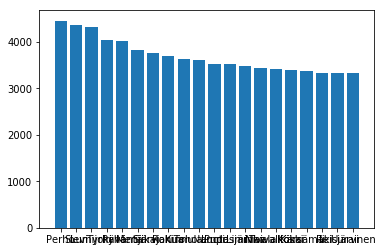

In [17]:
plt.bar(plotdat['kunta'], plotdat['lapsilisat_euroa_perhe'])

## Datastore-api

Jos et tarvitse koko aineistoa, voit suodattaa siitä osio SQL:llä käyttäen CKAN:n DataStore-rajapintaa.

Alla olevassa esimerkissä tehdään rajaus `kunta`-muuttujasta ja siis etsitään vaan kuntaa *Veteli* koskevat tiedot.

In [18]:
kunta = "Veteli"
taulu = resources[0]['id']
muuttuja = 'kunta'
urli = f'https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from "{taulu}" WHERE {muuttuja} LIKE \'{kunta}\''
urli_plain = f'https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from "{taulu}"'
#urli = "https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from \"%s\" WHERE %s LIKE '%s'" % (taulu, muuttuja, kunta)
#urli_plain = "https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from \"%s\"" % (taulu)
response = urlopen(urli_plain)
da = json.loads(response.read())
dataa = json_normalize(da['result']['records'])
#dataa
print(dataa.head())

                                          _full_text  _id  aika aikajakso  \
0  '11':13 '1115':7,9 '1340':12 '2008':4 '2466':8...    1  2008     vuosi   
1  '01':13 '137':9,11 '1502':14 '2008':4 '221':10...    2  2008     vuosi   
2  '1002':9,11 '1297':14 '2008':4 '2292':10 '2968...    3  2008     vuosi   
3  '1307':12 '2008':4 '2281':10 '46':11 '48':7,9 ...    4  2008     vuosi   
4  '1346':14 '1810':12 '2008':4 '21':15 '29':9,11...    5  2008     vuosi   

      kunta kuntanumero  lapset lapsilisat_euroa_lapsi lapsilisat_euroa_perhe  \
0  Alajärvi           5    2466                1340,11                2965,57   
1  Alajärvi           5     221                1502,84                2420,01   
2  Alajärvi           5    2292                1297,63                2968,59   
3  Alajärvi           5      85                1307,66                2281,46   
4  Alajärvi           5      40                1346,21                1810,41   

  maksetut_etuudet_euroa               perhetyyppi